# Deep Convolutional GANs

Brief introduction to Deep Convolutional Generative Adversarial Networks or DCGANs. This notebook is organized as follows:

1. **Research Paper**
1. **Background**
2. **Definition**
3. **Training DCGANs with CIFAR-10 dataset, Keras and TensorFlow**

---

## 1. Research Paper

* [Unsupervised Representation Learning With Deep Convolutional](https://arxiv.org/pdf/1511.06434.pdf)

## 2. Background

Brief definition of some concepts, such as convolution and Convolutional Neural Network (CNN) and GANs.

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

![convolution](https://devblogs.nvidia.com/wp-content/uploads/2015/11/convolution.png)

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **cost function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.

DCGAN are mainly composes of convolution layers without max pooling or fully connected layers. It uses convolutional stride and transposed convolution for the downsampling and the upsampling. 

### Network Design

<img src="../../img/network_design_dcgan.png" width="600"> 


### Cost Funcion


$$ \underset{G}{min} \: \underset{D}{max} \; V_{DCGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

> * Replace all max pooling with convolutional stride.
    Use transposed convolution for upsampling.
    Eliminate fully connected layers.
    Use Batch normalization except the output layer for the generator and the input layer of the discriminator.
    Use ReLU in the generator except for the output which uses tanh.
    Use LeakyReLU in the discriminator.*



## 4. Training DCGANs with CIFAR-10 dataset, Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the CIFAR-10 images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * Use the **Convolutional neural network**.
    * **LeakyReLU activation** and **BatchNormalization**.
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0003, beta_1=0.5)

* batch_size = 64
* epochs = 100


### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### Explore visual data

The CIFAR-10 images are RGB with 10 classes

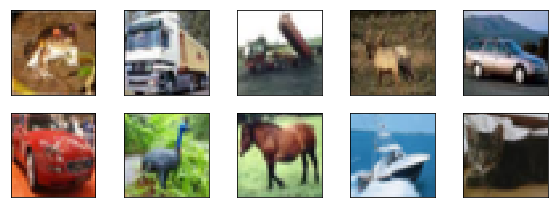

In [4]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

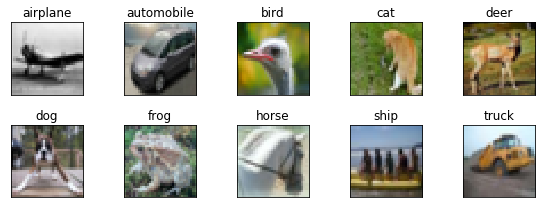

In [5]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [6]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (50000, 32, 32, 3)


### 2. Define model

#### Generator

In [8]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

#### Generator model visualization

In [9]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)         0         
__________

#### Discriminator


In [10]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [11]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)         1024      
__________

### 3. Compile model

#### Compile discriminator

In [12]:
# Optimizer

discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [13]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

#### GAN model vizualization

In [14]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4516739   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


### 4. Fit model


epoch = 1/100, d_loss=0.199, g_loss=0.032                                                                                                                         


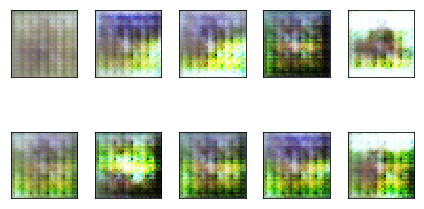

epoch = 2/100, d_loss=0.236, g_loss=0.755                                                                                                                         
epoch = 3/100, d_loss=0.301, g_loss=2.423                                                                                                                         
epoch = 4/100, d_loss=0.435, g_loss=3.903                                                                                                                        
epoch = 5/100, d_loss=0.352, g_loss=7.657                                                                                                                        
epoch = 6/100, d_loss=0.309, g_loss=4.160                                                                                                                        
epoch = 7/100, d_loss=0.203, g_loss=4.766                                                                                                                        
epoch = 8/100, d_loss=0.17

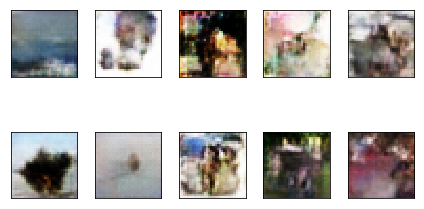

epoch = 12/100, d_loss=0.219, g_loss=3.815                                                                                                                         
epoch = 13/100, d_loss=0.290, g_loss=3.560                                                                                                                         
epoch = 14/100, d_loss=0.197, g_loss=3.993                                                                                                                         
epoch = 15/100, d_loss=0.319, g_loss=2.343                                                                                                                         
epoch = 16/100, d_loss=0.674, g_loss=4.979                                                                                                                         
epoch = 17/100, d_loss=0.564, g_loss=1.898                                                                                                                         
epoch = 18/100, 

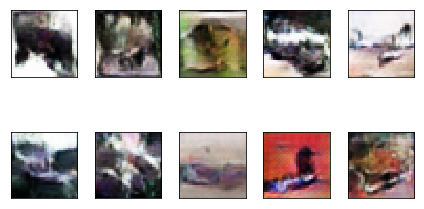

epoch = 22/100, d_loss=0.187, g_loss=5.832                                                                                                                         
epoch = 23/100, d_loss=0.190, g_loss=4.776                                                                                                                         
epoch = 24/100, d_loss=0.219, g_loss=6.539                                                                                                                         
epoch = 25/100, d_loss=0.191, g_loss=4.824                                                                                                                         
epoch = 26/100, d_loss=0.194, g_loss=8.347                                                                                                                         
epoch = 27/100, d_loss=0.179, g_loss=8.150                                                                                                                         
epoch = 28/100, 

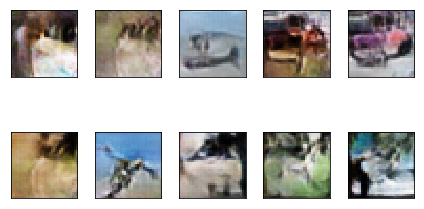

epoch = 32/100, d_loss=0.414, g_loss=4.059                                                                                                                         
epoch = 33/100, d_loss=0.226, g_loss=4.843                                                                                                                         
epoch = 34/100, d_loss=0.251, g_loss=4.736                                                                                                                         
epoch = 35/100, d_loss=0.238, g_loss=5.822                                                                                                                         
epoch = 36/100, d_loss=0.176, g_loss=6.593                                                                                                                         
epoch = 37/100, d_loss=0.279, g_loss=2.738                                                                                                                         
epoch = 38/100, 

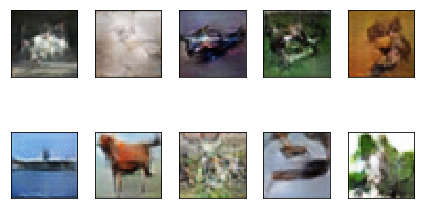

epoch = 42/100, d_loss=0.173, g_loss=5.446                                                                                                                         
epoch = 43/100, d_loss=0.297, g_loss=4.682                                                                                                                         
epoch = 44/100, d_loss=0.238, g_loss=4.901                                                                                                                         
epoch = 45/100, d_loss=0.268, g_loss=5.146                                                                                                                         
epoch = 46/100, d_loss=0.187, g_loss=6.953                                                                                                                         
epoch = 47/100, d_loss=0.186, g_loss=6.218                                                                                                                         
epoch = 48/100, 

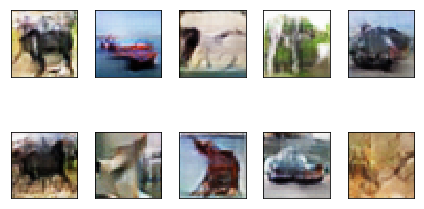

epoch = 52/100, d_loss=0.177, g_loss=8.598                                                                                                                         
epoch = 53/100, d_loss=0.223, g_loss=5.286                                                                                                                         
epoch = 54/100, d_loss=0.208, g_loss=6.450                                                                                                                         
epoch = 55/100, d_loss=0.180, g_loss=4.313                                                                                                                         
epoch = 56/100, d_loss=0.192, g_loss=5.116                                                                                                                         
epoch = 57/100, d_loss=0.178, g_loss=5.439                                                                                                                         
epoch = 58/100, 

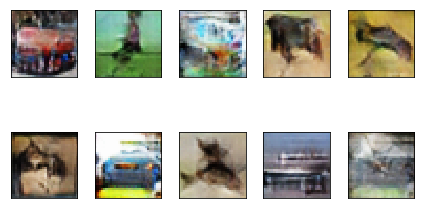

epoch = 62/100, d_loss=0.191, g_loss=9.410                                                                                                                         
epoch = 63/100, d_loss=0.183, g_loss=5.080                                                                                                                         
epoch = 64/100, d_loss=0.198, g_loss=5.334                                                                                                                         
epoch = 65/100, d_loss=0.264, g_loss=4.457                                                                                                                         
epoch = 66/100, d_loss=0.173, g_loss=7.162                                                                                                                         
epoch = 67/100, d_loss=0.301, g_loss=3.156                                                                                                                         
epoch = 68/100, 

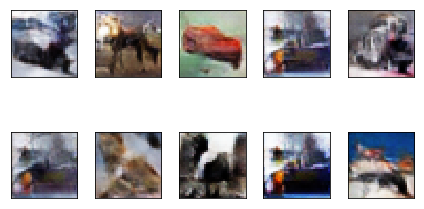

epoch = 72/100, d_loss=0.201, g_loss=4.672                                                                                                                         
epoch = 73/100, d_loss=0.226, g_loss=3.614                                                                                                                         
epoch = 74/100, d_loss=0.181, g_loss=4.593                                                                                                                         
epoch = 75/100, d_loss=0.187, g_loss=5.903                                                                                                                         
epoch = 76/100, d_loss=0.186, g_loss=5.240                                                                                                                         
epoch = 77/100, d_loss=0.173, g_loss=6.105                                                                                                                         
epoch = 78/100, 

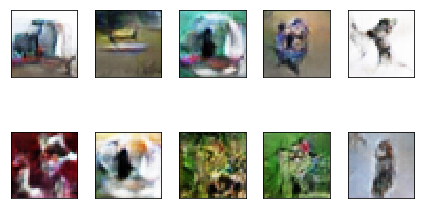

epoch = 82/100, d_loss=0.172, g_loss=5.975                                                                                                                         
epoch = 83/100, d_loss=0.192, g_loss=4.759                                                                                                                         
epoch = 84/100, d_loss=0.188, g_loss=4.973                                                                                                                         
epoch = 85/100, d_loss=0.178, g_loss=5.603                                                                                                                         
epoch = 86/100, d_loss=0.181, g_loss=5.809                                                                                                                         
epoch = 87/100, d_loss=0.203, g_loss=4.083                                                                                                                         
epoch = 88/100, 

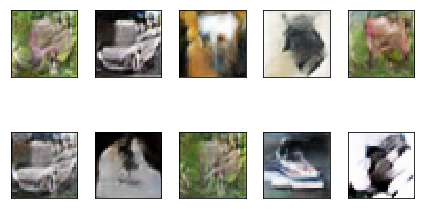

epoch = 92/100, d_loss=0.174, g_loss=9.473                                                                                                                         
epoch = 93/100, d_loss=0.172, g_loss=5.660                                                                                                                         
epoch = 94/100, d_loss=0.192, g_loss=4.200                                                                                                                         
epoch = 95/100, d_loss=0.174, g_loss=6.412                                                                                                                        
epoch = 96/100, d_loss=0.170, g_loss=5.727                                                                                                                         
epoch = 97/100, d_loss=0.180, g_loss=5.386                                                                                                                         
epoch = 98/100, d

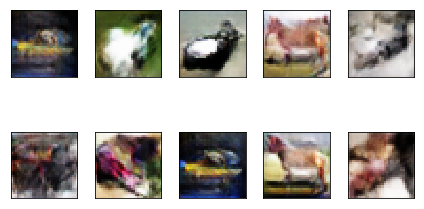

In [15]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

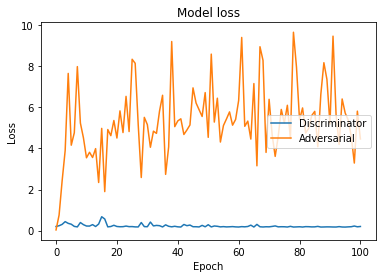

In [16]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)
* [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)